# Image Classification: Data Visualization and Model Exploration

## Introduction

This notebook demonstrates the importance of effective data visualization and exploratory data analysis (EDA) in image classification problems. We'll walk through a systematic approach to understanding image data before applying machine learning models.


### What are some reasons to care about data visualization?

### Answer:



*   Reduction in effort to understand results
*   Spatial relationships and color to differentiate data



## 1. Setting Up the Environment

In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, Module
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import warnings

# Set up plotting aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette("viridis")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

## 2. Loading the Dataset

Load the dataset of Metal Defects of different Depths by Eddy Current Testing (MDDECT)
Data set has dimension (N,8,2,5,20,1250,2)
These represent number of experiments, scanning angles, foreword/backward movements, repeats, classes, temporal points, and channels)
The order of classes is 2.0 mm, 1.9 mm, 1.8 mm, …, 0.4 mm, 0.3 mm, lift-off and normal.

In [16]:
# Load the Fashion MDDECT dataset
test = np.load('MDDECT_v1_test.npy')
train = np.load('MDDECT_v1_train.npy')

# Define class names
class_names = ["2.0", "1.9","1.8","1.7","1.6","1.5","1.4","1.3","1.2","1.1","1.0","0.9","0.8","0.7","0.6","0.5","0.4","0.3","Lift-Off","Normal"]

# Original shape

print(test.shape)

# Get the first 5 dims (3, 8, 2, 5, 20)
idx = np.indices(test.shape[:5])  # Shape: (5, 3, 8, 2, 5, 20)

# Reshape each index into (4800,)
flat_indices = [dim.flatten() for dim in idx]  # List of 5 arrays of shape (4800,)

# Stack to get shape (4800, 5), where each row is the original indices (i,j,k,l,m)
test_index_map = np.stack(flat_indices, axis=1)

# Reshape the data to (4800, 1250, 2)
x_test = test.reshape(-1, 1250, 2)
y_test = test_index_map[:, 4]  # Shape: (4800,)
# Get the first 5 dims (3, 8, 2, 5, 20)
idx = np.indices(train.shape[:5])  # Shape: (5, 3, 8, 2, 5, 20)

# Reshape each index into (4800,)
flat_indices = [dim.flatten() for dim in idx]  # List of 5 arrays of shape (4800,)

# Stack to get shape (4800, 5), where each row is the original indices (i,j,k,l,m)
train_index_map = np.stack(flat_indices, axis=1)

# Reshape the data to (4800, 1250, 2)
x_train = train.reshape(-1, 1250, 2)
y_train = train_index_map[:, 4]  # Shape: (4800,)

#Display basic dataset information
print(f"Training images shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test images shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

print(class_names[y_train[1]])

(3, 8, 2, 5, 20, 1250, 2)
Training images shape: (43200, 1250, 2)
Training labels shape: (43200,)
Test images shape: (4800, 1250, 2)
Test labels shape: (4800,)
Number of classes: 20
Class names: ['2.0', '1.9', '1.8', '1.7', '1.6', '1.5', '1.4', '1.3', '1.2', '1.1', '1.0', '0.9', '0.8', '0.7', '0.6', '0.5', '0.4', '0.3', 'Lift-Off', 'Normal']
1.9


## 3. Exploratory Data Analysis (EDA)

### Visualizing Sample Images

Let's start by visualizing sample images from different classes.

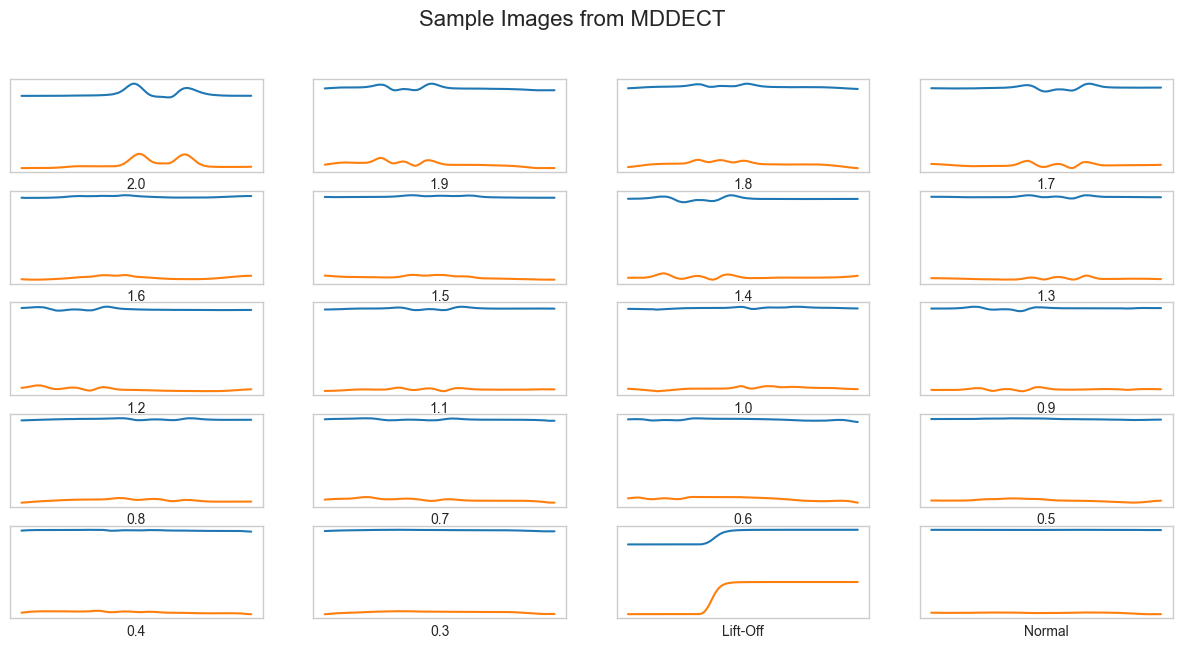

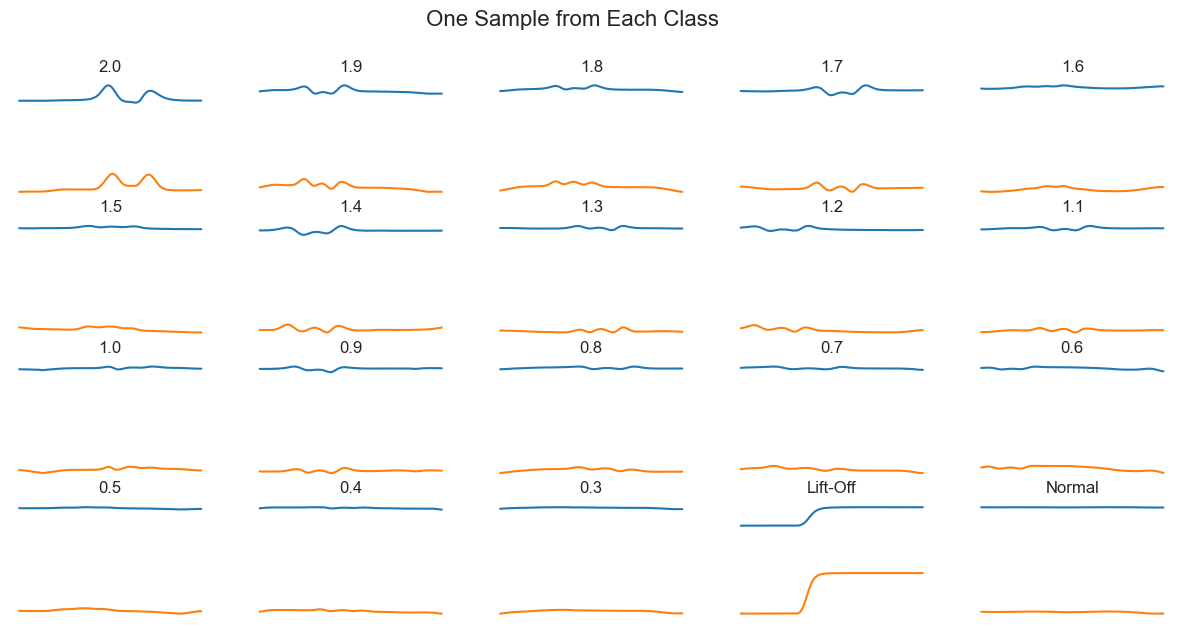

In [ ]:
# Display a grid of sample images
plt.figure(figsize=(15, 7))
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.plot(x_train[i])
    plt.xlabel(class_names[y_train[i]])
plt.suptitle('Sample Images from MDDECT', fontsize=16)
plt.show()

# Display one sample from each class
plt.figure(figsize=(15, 7))
for i in range(20):
    # Find the first image of each class
    idx = np.where(y_train == i)[0][0]
    plt.subplot(4, 5, i+1)
    plt.plot(x_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle('One Sample from Each Class', fontsize=16)
plt.show()

### 3.2 Exploring Class Distribution

Let's check if our dataset is balanced across classes.

In [6]:
# Analyze class distribution
def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Class': [class_names[i] for i in unique],
        'Count': counts
    })

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='Count', data=df, palette='viridis')
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Print statistics
    print(f"Total samples: {sum(counts)}")
    print(f"Minimum class size: {min(counts)} ({class_names[np.argmin(counts)]})")
    print(f"Maximum class size: {max(counts)} ({class_names[np.argmax(counts)]})")
    print(f"Class imbalance ratio (max/min): {max(counts)/min(counts):.2f}")

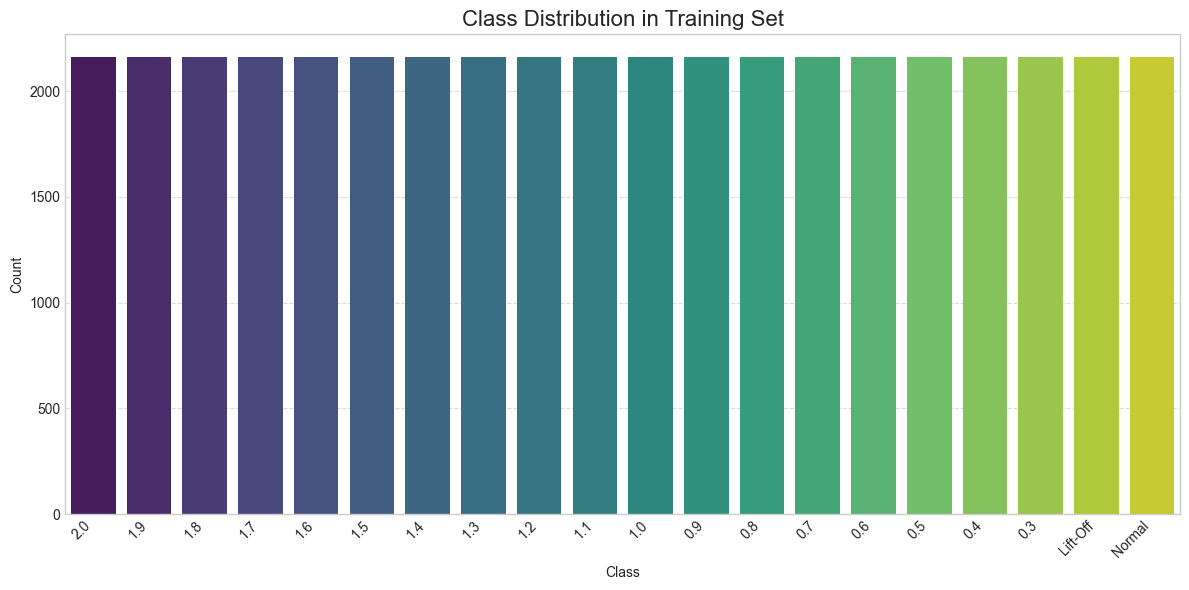

Total samples: 43200
Minimum class size: 2160 (2.0)
Maximum class size: 2160 (2.0)
Class imbalance ratio (max/min): 1.00


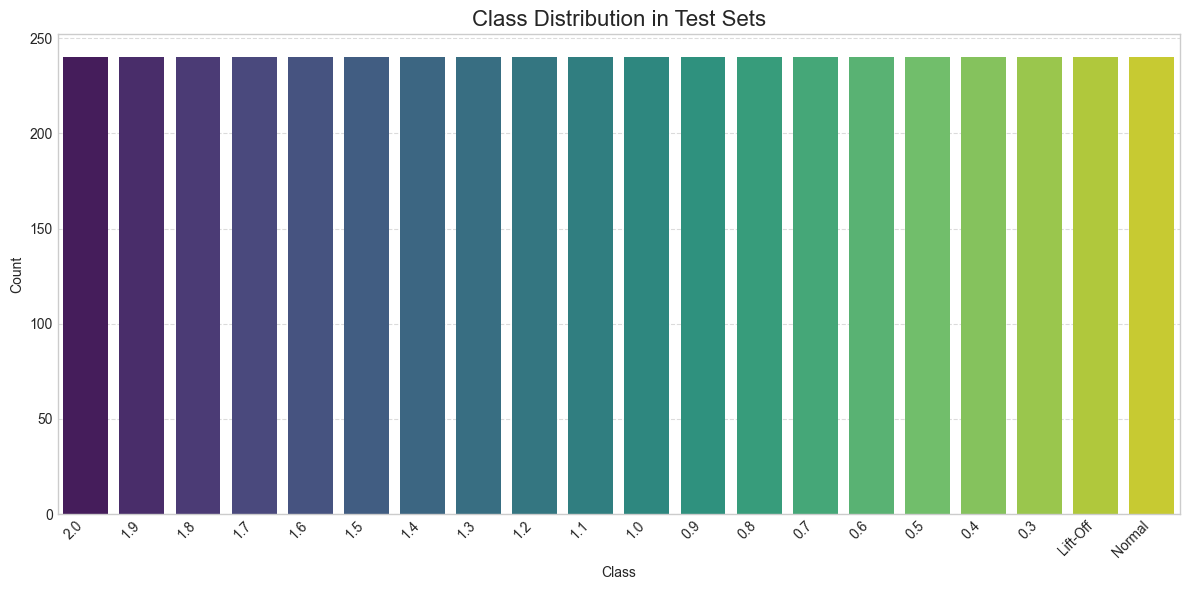

Total samples: 4800
Minimum class size: 240 (2.0)
Maximum class size: 240 (2.0)
Class imbalance ratio (max/min): 1.00


In [9]:

# Plot class distribution for training and test sets
plot_class_distribution(y_train, "Class Distribution in Training Set")
plot_class_distribution(y_test, "Class Distribution in Test Sets")


### Once you have completed sanity checks, what's the next step?

### Answer : Plot Average and Standard Deviation of the inputs

### Image Intensity Analysis

Let's analyze the pixel intensity distributions across different classes.

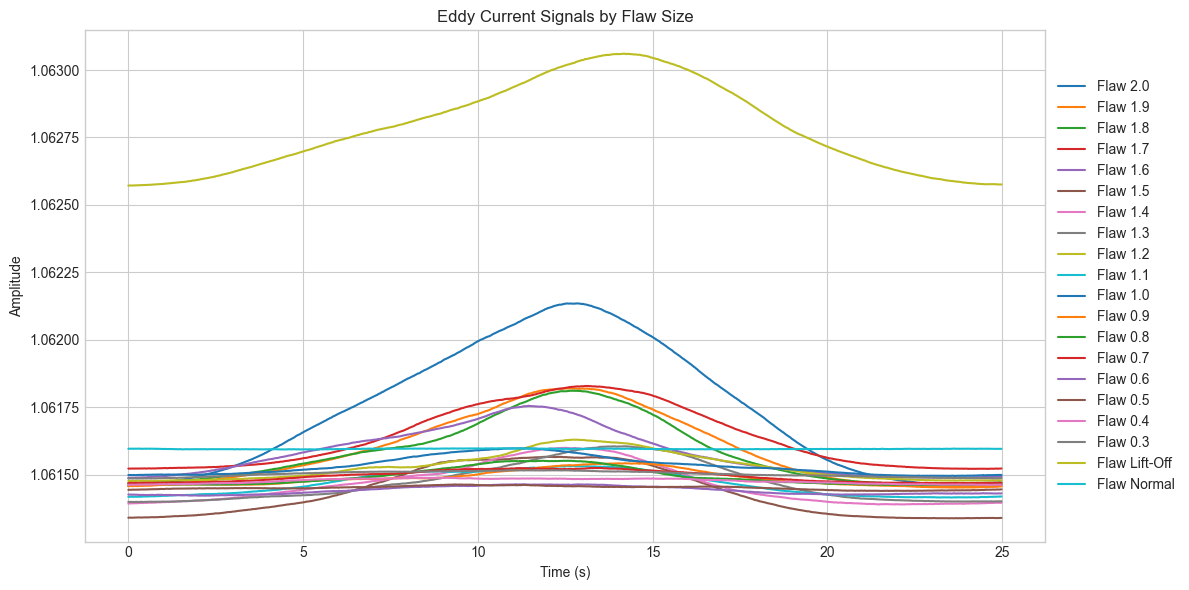

In [17]:
# plot the mean value of each class
time = np.arange(0, 1250*0.02, 0.02)
plt.figure(figsize=(12, 6))
for class_name in class_names:
    class_idx = class_names.index(class_name)
    class_samples = x_train[y_train == class_idx]  # shape: (N, 1250, 2)

    # Take average over all samples for smoother curve
    mean_curve = class_samples[:, :, 0].mean(axis=0)

    plt.plot(time,mean_curve, label=f"Flaw {class_name}")

plt.title("Eddy Current Signals by Flaw Size")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(True)


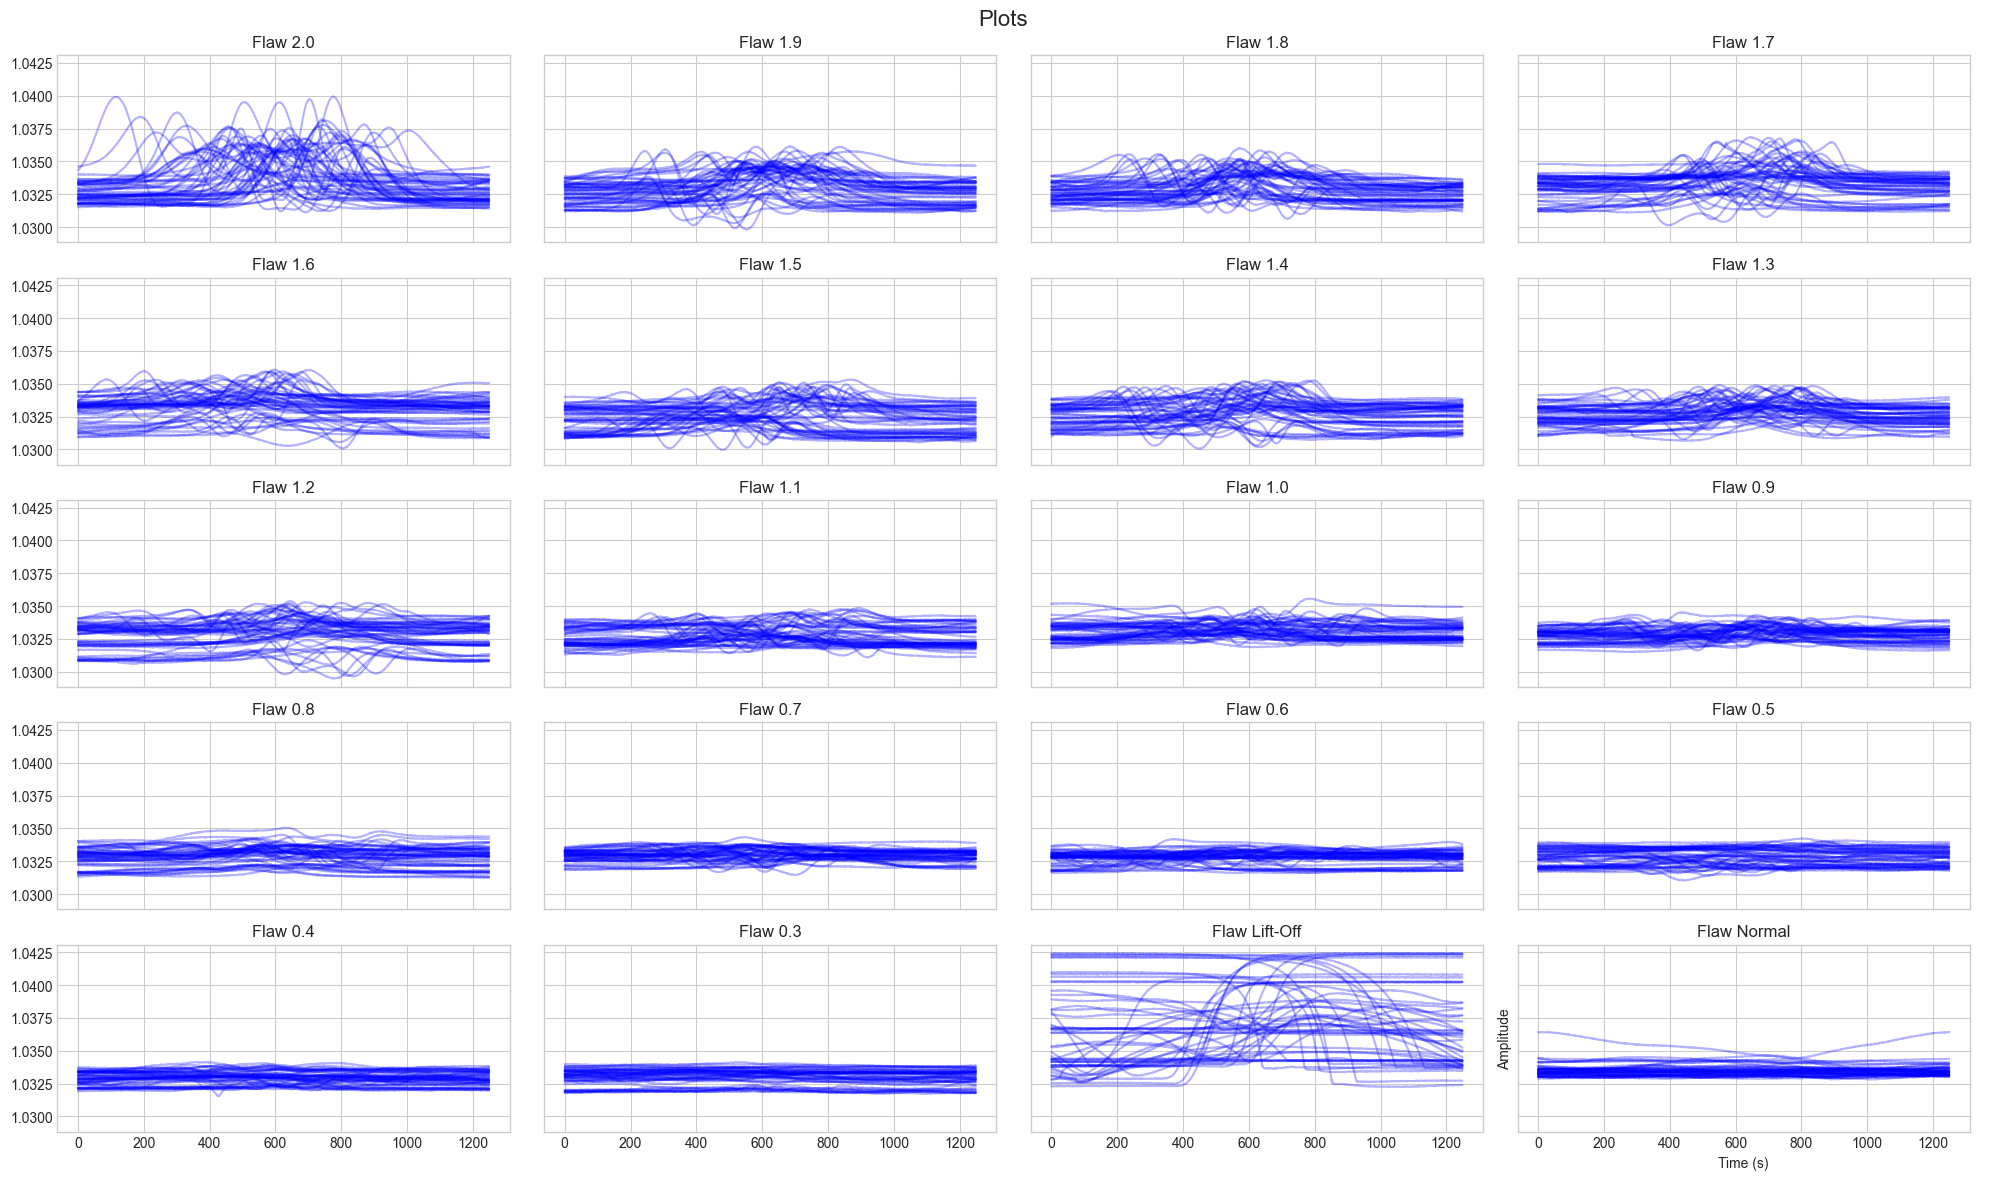

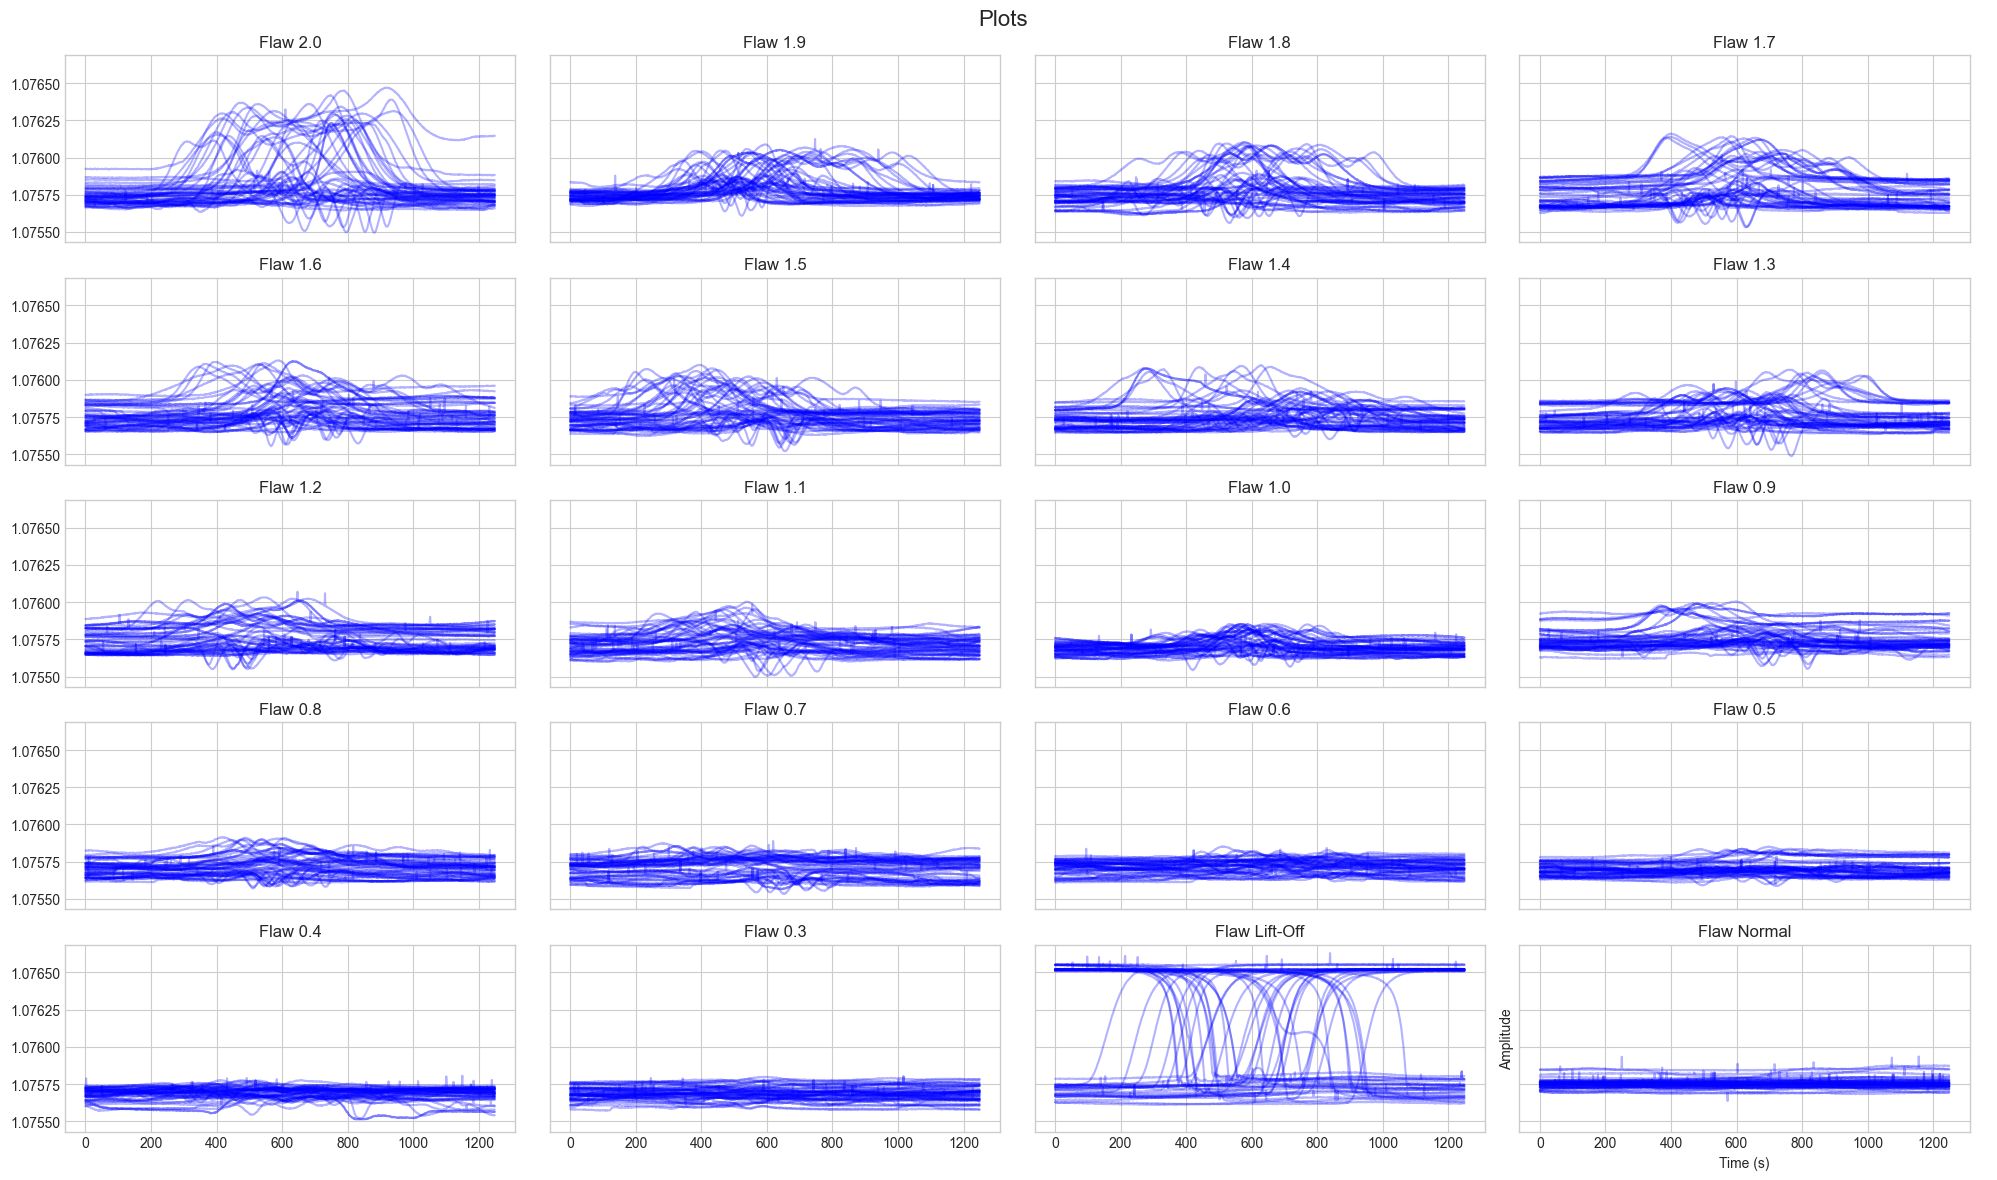

In [37]:
# plot the mean value of each class
time = np.arange(0, 1250*0.02, 0.02)
fig, axes = plt.subplots(5, 4, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()
for i, class_name in enumerate(class_names):
    ax = axes[i]
    class_idx = class_names.index(class_name)
    class_samples = x_train[y_train == class_idx]  # shape: (N, 1250, 2)
    samples = class_samples[:, :, 0] 
    # There are 2160 plots for each class, plot 50 samples from the first
    for spectrum in samples[:50,:]:
        ax.plot(spectrum, alpha=0.3, color='blue')
    ax.set_title(f"Flaw {class_name}")
    ax.grid(True)
fig.suptitle("Plots", fontsize=16)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(True)
plt.show()


fig, axes = plt.subplots(5, 4, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()
for i, class_name in enumerate(class_names):
    ax = axes[i]
    class_idx = class_names.index(class_name)
    class_samples = x_train[y_train == class_idx]  # shape: (N, 1250, 2)
    samples = class_samples[:, :, 0] 
    # There are 2160 plots for each class,plot last 50 samples from each class
    for spectrum in samples[2110:,:]:
        ax.plot(spectrum, alpha=0.3, color='blue')

    ax.set_title(f"Flaw {class_name}")
    ax.grid(True)
fig.suptitle("Plots", fontsize=16)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(True)
plt.show()

### When making plots, how should you pick colors for your plots?



### t-SNE Visualization for Class Separation

t-SNE is a dimensionality reduction technique that can help visualize high-dimensional data. Let's use it to see if our classes are naturally separable.

In [38]:
print(class_names)

['2.0', '1.9', '1.8', '1.7', '1.6', '1.5', '1.4', '1.3', '1.2', '1.1', '1.0', '0.9', '0.8', '0.7', '0.6', '0.5', '0.4', '0.3', 'Lift-Off', 'Normal']


In [39]:
# Use t-SNE to visualize class separation
from sklearn.manifold import TSNE

# Sample a subset of images for t-SNE (for computational efficiency)
n_samples = 2000
sample_indices = np.random.choice(len(x_train), size=n_samples, replace=False)
sample_images = x_train[sample_indices].reshape(n_samples, -1)  # Flatten images
sample_labels = y_train[sample_indices]

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(sample_images)
print("t-SNE completed.")

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': tsne_result[:, 0],
    'y': tsne_result[:, 1],
    'label': [class_names[label] for label in sample_labels]
})



Applying t-SNE...
t-SNE completed.


### Bad

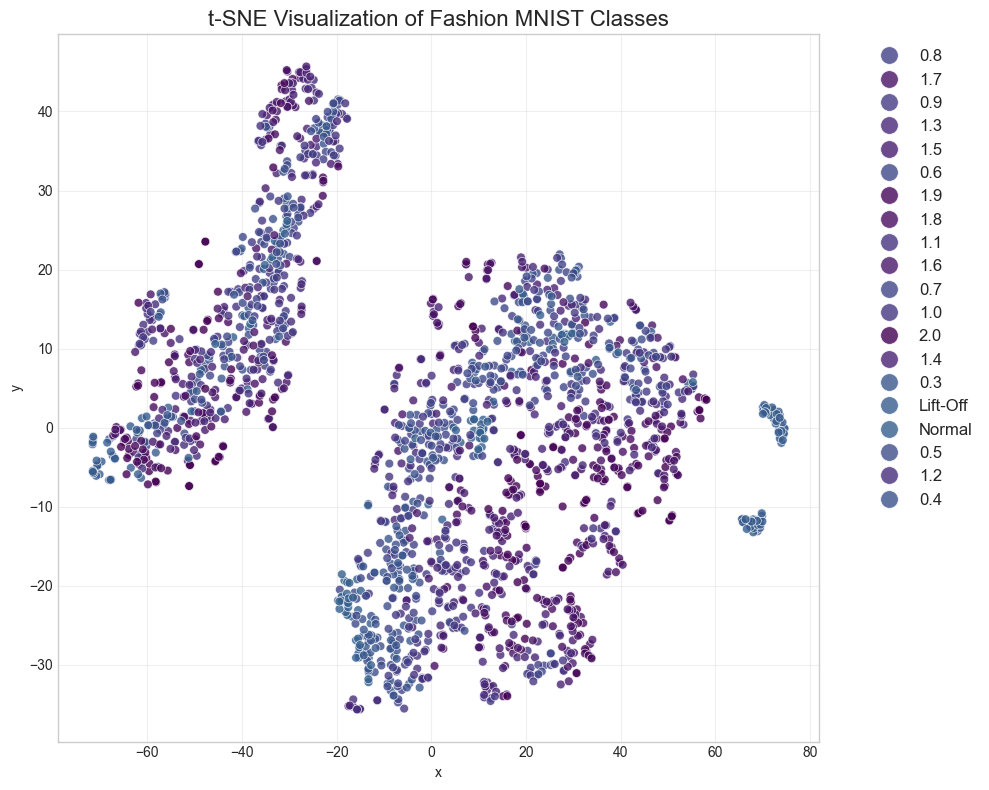

In [40]:
# Use the viridis colormap
from matplotlib.cm import viridis

# Create a discrete colormap with 10 colors (one for each class)
n_colors = len(class_names)
viridis_colors = viridis(np.linspace(0, 0.3, n_colors))

# Create a custom palette dictionary mapping each class to a color
custom_palette = {class_name: viridis_colors[i] for i, class_name in enumerate(class_names)}

# Plot t-SNE results with the custom palette
plt.figure(figsize=(10, 8))  # Larger figure to accommodate the bigger legend
sns.scatterplot(x='x', y='y', hue='label', data=tsne_df, palette=custom_palette, alpha=0.8, s=40)
plt.title('t-SNE Visualization of Fashion MNIST Classes', fontsize=16)

# Create a bigger legend with larger font size and marker size
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, markerscale=2)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Good

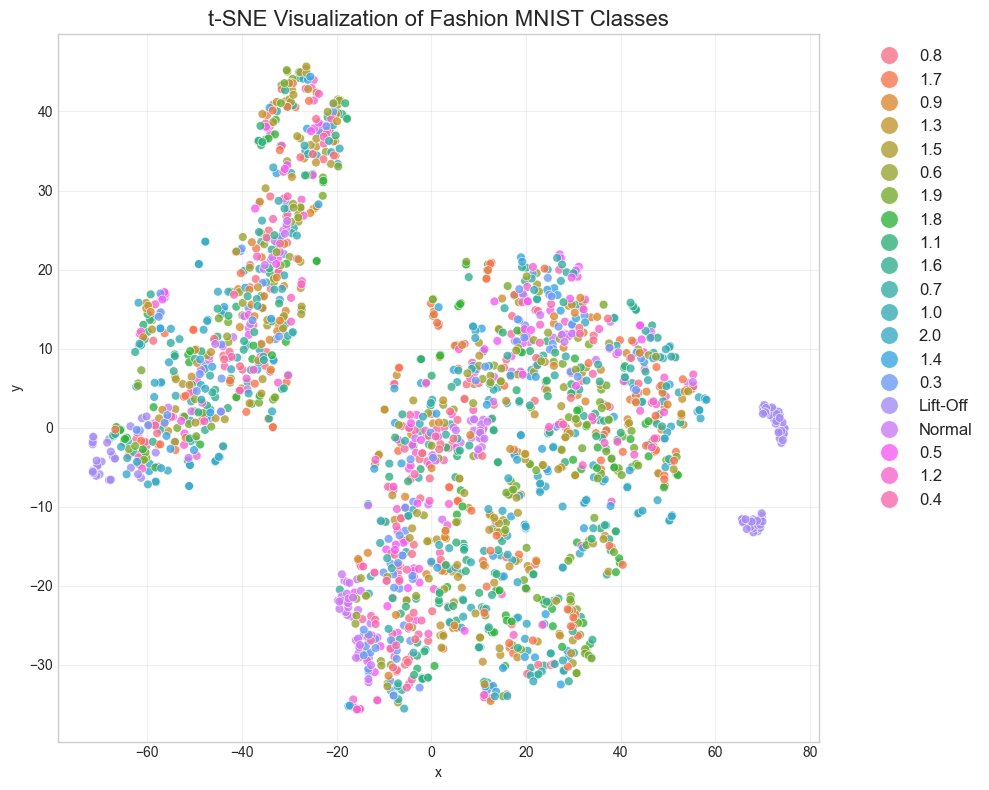

In [41]:
# Plot t-SNE results'
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='label', data=tsne_df, alpha=0.8, s=40)
plt.title('t-SNE Visualization of Fashion MNIST Classes', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, markerscale=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Better

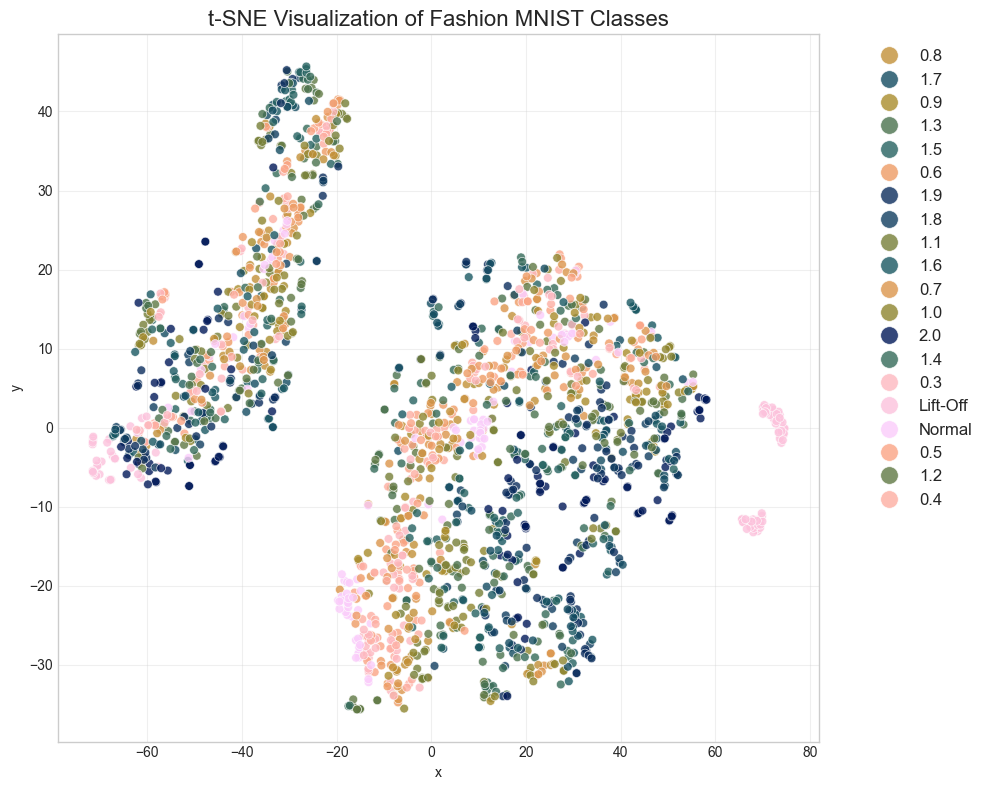

In [46]:
# First, let's install the Scientific Colour Maps package if not already installed

import cmcrameri.cm as cmc


# Define the class names
class_names = ["2.0", "1.9","1.8","1.7","1.6","1.5","1.4","1.3","1.2","1.1","1.0","0.9","0.8","0.7","0.6","0.5","0.4","0.3","Lift-Off","Normal"]

# Use a categorical colormap - create a discrete version of batlow
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Create a discrete colormap with 10 colors (one for each class)
n_colors = len(class_names)
batlow_colors = cmc.batlow(np.linspace(0, 1, n_colors))
batlow10 = ListedColormap(batlow_colors)
# Create a custom palette dictionary mapping each class to a color
custom_palette = {class_name: batlow_colors[i] for i, class_name in enumerate(class_names)}

# Plot t-SNE results with the custom palette
plt.figure(figsize=(10, 8))  # Made the figure larger to accommodate the bigger legend
sns.scatterplot(x='x', y='y', hue='label', data=tsne_df, palette=custom_palette, alpha=0.8, s=40)
plt.title('t-SNE Visualization of Fashion MNIST Classes', fontsize=16)

# Create a bigger legend with larger font size and marker size
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, markerscale=2)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
## Visualization Change

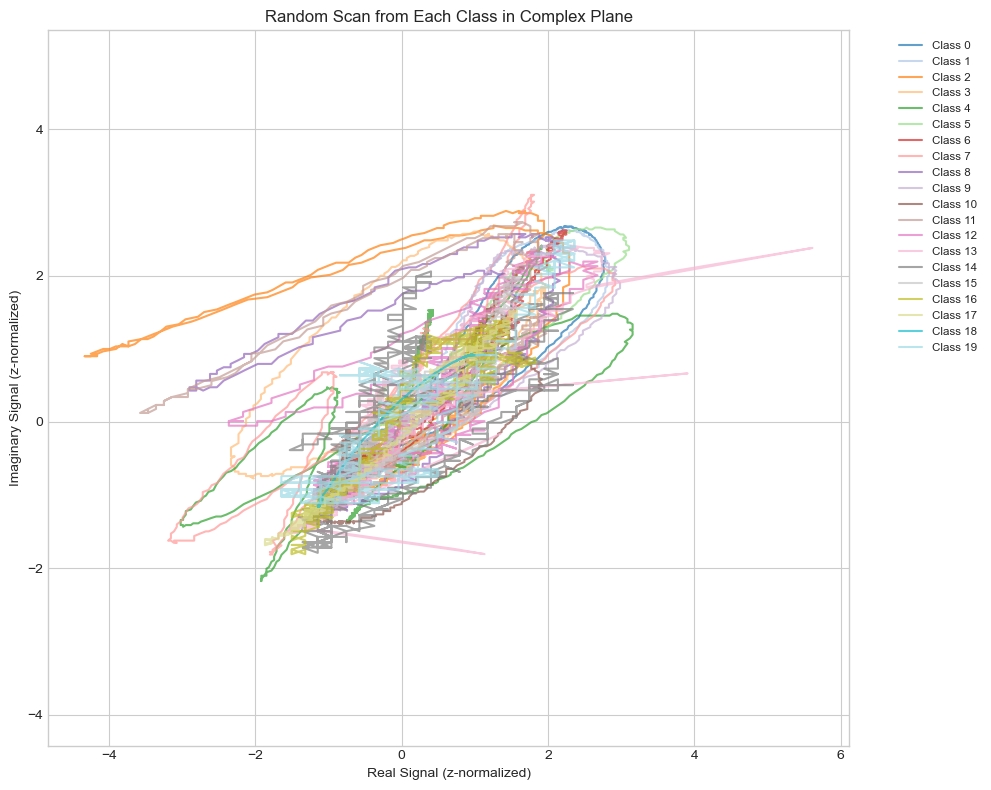

In [26]:
import random

# Define axis indices for readability
AXIS = {
    'experiment': 0,
    'angle': 1,
    'movement': 2,    # 0 = forward, 1 = backward
    'repeat': 3,
    'class': 4,
    'time': 5,
    'channel': 6,     # 0 and 1 (probably different sensor channels)
}

# Helper functions

def split_by_movement(train):
    """Split into forward and backward scans"""
    forward = train[:, :, 0, :, :, :, :]  # movement == 0
    backward = train[:, :, 1, :, :, :, :] # movement == 1
    return forward, backward

def split_by_repeat(train):
    """Split into individual repeat trials"""
    return [train[:, :, :, i, :, :, :] for i in range(train.shape[AXIS['repeat']])]

def split_by_class(train):
    """Split into list, one array per class"""
    return [train[:, :, :, :, i, :, :] for i in range(train.shape[AXIS['class']])]

def split_by_channel(train):
    """Split into channel 0 and channel 1"""
    channel_0 = train[..., 0]
    channel_1 = train[..., 1]
    return channel_0, channel_1

def get_single_sample(train, experiment_idx=0, angle_idx=0, movement_idx=0, repeat_idx=0, class_idx=0, channel_idx=0):
    """Extract a single time series"""
    return train[experiment_idx, angle_idx, movement_idx, repeat_idx, class_idx, :, channel_idx]

# Example usage:

# a. Split forward/backward
forward_data, backward_data = split_by_movement(train)

# b. Split by repeats
repeats = split_by_repeat(train)  # list of 5 arrays

# c. Split by class
classes = split_by_class(train)   # list of 20 arrays

# d. Split by channel
channel0_data, channel1_data = split_by_channel(train)
# Define number of classes
num_classes = 20

# Color map
colors = plt.cm.get_cmap('tab20', num_classes)

# Initialize plot
plt.figure(figsize=(10, 8))

# Loop over classes
for class_idx in range(num_classes):
    # Randomly choose experiment, angle, movement, repeat
    exp_idx = random.randint(0, train.shape[0] - 1)
    angle_idx = random.randint(0, 7)
    movement_idx = random.randint(0, 1)
    repeat_idx = random.randint(0, 4)

    # Extract real and imaginary parts
    real_signal = train[exp_idx, angle_idx, movement_idx, repeat_idx, class_idx, :, 0]  # Channel 0
    imag_signal = train[exp_idx, angle_idx, movement_idx, repeat_idx, class_idx, :, 1]  # Channel 1

    # Z-normalize
    real_norm = (real_signal - np.mean(real_signal)) / np.std(real_signal)
    imag_norm = (imag_signal - np.mean(imag_signal)) / np.std(imag_signal)

    # Plot
    plt.plot(real_norm, imag_norm, color=colors(class_idx), label=f'Class {class_idx}', alpha=0.7)

# Formatting
plt.title('Random Scan from Each Class in Complex Plane')
plt.xlabel('Real Signal (z-normalized)')
plt.ylabel('Imaginary Signal (z-normalized)')
plt.grid(True)
plt.axis('equal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

## 4. Image Preprocessing

In [47]:


print(f"Training images shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test images shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

print(class_names[y_train[1]])

Training images shape: (43200, 1250, 2)
Training labels shape: (43200,)
Test images shape: (4800, 1250, 2)
Test labels shape: (4800,)
Number of classes: 20
Class names: ['2.0', '1.9', '1.8', '1.7', '1.6', '1.5', '1.4', '1.3', '1.2', '1.1', '1.0', '0.9', '0.8', '0.7', '0.6', '0.5', '0.4', '0.3', 'Lift-Off', 'Normal']
1.9


## 5. Baseline Model Building and Evaluation

Let's start with simple models to establish a performance baseline.

In [55]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
print("^^^^ if cuda is printed, we are using the GPU!")
batch_size = 100

x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(DEVICE)

x_test_rensor = torch.tensor(x_test, dtype=torch.float32).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = TensorDataset(x_test_rensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)




cpu
^^^^ if cuda is printed, we are using the GPU!


In [60]:
def my_model() -> nn.Module:
    model = nn.Sequential(
        nn.Flatten(),                    # From (B, 1250, 2) → (B, 2500)
        nn.Linear(1250 * 2, 625),
        nn.ReLU(),
        nn.Linear(625, 160),
        nn.ReLU(),
        nn.Linear(160, 80),
        nn.ReLU(),
        nn.Linear(80, 20)
    )
    return model

In [66]:
def train_model(model, train_loader, batch_size, epochs=50, lr=0.001):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CrossEntropyLoss()
    all_train_loss = []
    all_train_accuracy = []

    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        total = 0
        model.train()

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred_classes = torch.argmax(outputs, dim=1)
            train_correct += (pred_classes == labels).sum().item()
            total += labels.size(0)

        avg_loss = train_loss / len(train_loader)
        accuracy = train_correct / total

        all_train_loss.append(avg_loss)
        all_train_accuracy.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(all_train_loss, "o-", c="tab:red")
    plt.title("Loss")
    plt.xlabel("Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(all_train_accuracy, "o-", c="tab:blue")
    plt.title("Accuracy")
    plt.xlabel("Epochs")

    plt.tight_layout()
    plt.show()

    return model

def evaluate_model(model, test_loader,batch_size):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    criterion = CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_accuracy += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    test_accuracy /= (batch_size * len(test_loader))
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/10], Loss: 2.9978, Accuracy: 0.0487
Epoch [2/10], Loss: 2.9961, Accuracy: 0.0483
Epoch [3/10], Loss: 2.9961, Accuracy: 0.0481
Epoch [4/10], Loss: 2.9960, Accuracy: 0.0480
Epoch [5/10], Loss: 2.9960, Accuracy: 0.0480
Epoch [6/10], Loss: 2.9960, Accuracy: 0.0494
Epoch [7/10], Loss: 2.9960, Accuracy: 0.0480
Epoch [8/10], Loss: 2.9960, Accuracy: 0.0480
Epoch [9/10], Loss: 2.9960, Accuracy: 0.0475
Epoch [10/10], Loss: 2.9960, Accuracy: 0.0478


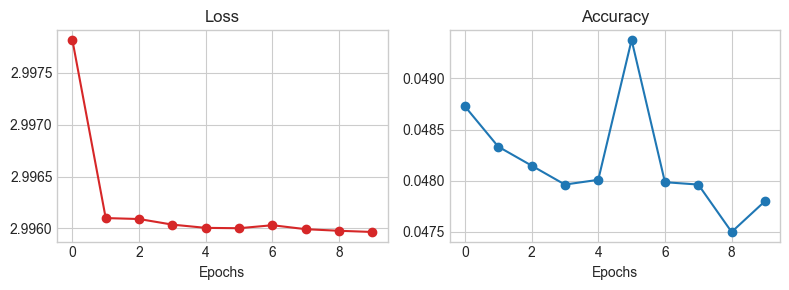

Test Loss: 2.9957, Test Accuracy: 0.0500


In [ ]:
model = my_model().to(DEVICE)
model = train_model(model, train_loader,batch_size, epochs=10, lr=0.001)
model = evaluate_model(model, test_loader,batch_size)
# This loss value and the accuracy means that the model is randomly guessing the classes
# Expected with a very simple neural network.
